 # Prescreen results

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import warnings
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable

import nelpy as nel
import nelpy.plotting as npl

npl.setup()

get_ipython().run_line_magic('matplotlib', 'inline')

warnings.filterwarnings("ignore")



/mnt/d/Development/Python/nelpy/nelpy/plotting/decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
datadirs = ['/mnt/d/Data/Etienne/',
    'D:/Dropbox/neoReader/']

## conda install pandas=0.19.2

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

if fileroot is None:
    raise FileNotFoundError('datadir not found')

load_from_nel = True

# load from nel file:
if load_from_nel:  
    jar = nel.load_pkl(fileroot + 'gor01vvp01pin01_processed_speed.nel')
    aux_data = jar.aux_data
    jar = nel.load_pkl(fileroot + 'gor01vvp01pin01_tables_speed.nel')
    df = jar.df
    df2 = jar.df2
    jar = nel.load_pkl(fileroot + 'score_all_sessions_5000_35000.nel') # needs to be modified to include pin01 bayes
    score_results = jar.results
    del jar
    
jar = nel.load_pkl('sessions-segments.nel')
sessions, segments = jar.sessions, jar.segments



In [63]:
def plot_all_PBEs(bst, spiketrainarray, tuningcurve, tc_placecells, idx=None, title_str=None, size=None):
    if idx is not None:
        bst = bst[idx]
    st = spiketrainarray
    tc = tuningcurve
    tc_placecells = tc_placecells

    no = tc_placecells.get_peak_firing_order_ids()
    st.reorder_units_by_ids(no, inplace=True)

    st_cut = st[bst.support]
    st_cut._support = bst.support # hacky fix so that we can plot events out of order
    st_cut = nel.utils.collapse_time(st_cut)

    # decode neural activity
    posterior, bdries, mode_pth, mean_pth = nel.decoding.decode1D(bst=bst, ratemap=tc, xmax=310)

    if size == 'big':
        figwidth = 0.8 * bst.n_bins
    else:
        figwidth = 0.08 * bst.n_bins
        
    with npl.FigureManager(show=True, figsize=(figwidth,5)) as (fig, ax):
        npl.utils.skip_if_no_output(fig)

        pixel_width = 0.5

        npl.imagesc(x=np.arange(bst.n_bins), y=np.arange(311), data=posterior, cmap=plt.cm.Spectral_r, ax=ax)
        npl.utils.yticks_interval(310)
        npl.utils.no_yticks(ax)
        # plt.imshow(posterior, cmap=plt.cm.Spectral_r, interpolation='none', aspect='auto')
        ax.vlines(np.arange(bst.lengths.sum())-pixel_width, *ax.get_ylim(), lw=1, linestyle=':', color='0.8')
        ax.vlines(np.cumsum(bst.lengths)-pixel_width, *ax.get_ylim(), lw=1)

        ax.set_xlim(-pixel_width, bst.lengths.sum()-pixel_width)

        event_centers = np.insert(np.cumsum(bst.lengths),0,0)
        event_centers = event_centers[:-1] + bst.lengths/2 - 0.5

        ax.set_xticks(event_centers);
        if idx is not None:
            ax.set_xticklabels(idx);
        else:
            ax.set_xticklabels(np.arange(bst.n_epochs));

        npl.utils.no_xticks(ax)

        divider = make_axes_locatable(ax)
        if size == 'big':
            axRaster = divider.append_axes("top", size=1.5, pad=0)
        else:
            axRaster = divider.append_axes("top", size=1, pad=0)

        npl.rasterplot(st_cut, vertstack=True, ax=axRaster, lh=2)
        axRaster.set_xlim(st_cut.support.time.squeeze())
        bin_edges = np.linspace(st_cut.support.time[0,0],st_cut.support.time[0,1], bst.n_bins+1)
    #     axRaster.vlines(bin_edges, *ax.get_ylim(), lw=1, linestyle=':', color='0.2')
        axRaster.vlines(bin_edges[np.cumsum(bst.lengths)], *ax.get_ylim(), lw=1, color='0.2')
        npl.utils.no_xticks(axRaster)
        npl.utils.no_xticklabels(axRaster)
        npl.utils.no_yticklabels(axRaster)
        npl.utils.no_yticks(axRaster)
        ax.set_ylabel('position [cm]')
        ax.set_xlabel('time bins (20 ms)')
        if title_str:
            fig.suptitle(title_str)
        npl.utils.clear_left_right(axRaster)
        npl.utils.clear_top_bottom(axRaster)



In [5]:
min_n_placecells = 20
min_n_PBEs = 30
df2_subset = df2[(df2.n_PBEs >= min_n_PBEs) & (df2.n_placecells >= min_n_placecells)]


In [6]:
z_scores = np.array(df2_subset['prescreen_z'].values.tolist())
z_order = np.argsort(z_scores)[::-1] # ascending order

PlotAllSessions = False
if PlotAllSessions:
    for session, segment in zip(np.array(sessions)[z_order], np.array(segments)[z_order]):
        bst = aux_data[session][segment]['PBEs']
        st = aux_data[session][segment]['st_placecells']
        tc = aux_data[session][segment]['tc']
        tc_placecells = aux_data[session][segment]['tc_placecells']
        evt_order = np.argsort(score_results[session][segment]['scores_bayes_percentile']).tolist()[::-1]
        title_str = str(session) + ': ' + str(segment) + '; events ordered by decreasing Bayesian score percentile'
        plot_all_PBEs(bst, st, tc, tc_placecells, idx=evt_order, title_str=title_str)



 # Look at an example session

In [8]:
session = '16-40-19'; segment = 'short'
# session = '1-22-43'; segment = 'short'
bst = aux_data[session][segment]['PBEs']
st = aux_data[session][segment]['st_placecells']
tc = aux_data[session][segment]['tc']
tc_placecells = aux_data[session][segment]['tc_placecells']
bst.n_epochs

scores_bayes_percentile = score_results[session][segment]['scores_bayes_percentile']
scores_hmm_percentile = score_results[session][segment]['scores_hmm_percentile']

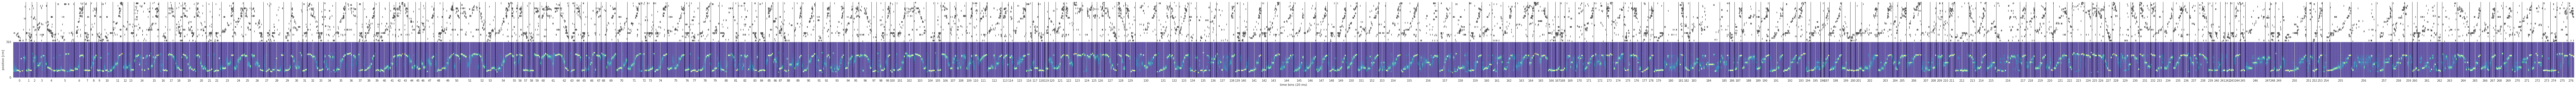

In [49]:
plot_all_PBEs(bst, st, tc, tc_placecells)

### _Etienne has gone through and scored all the sequences in this session_

In [9]:
goodseqs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
              21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
              40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
              59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
              78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
              97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
              113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
              128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
              143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
              158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 
              173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 
              188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
              203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
              218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
              233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 
              248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 
              263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276]

badseqs = [0,2,3,14,34,47,55,82,88,108,126,135,137,153,180,181,184,185,207,229,237,251,
          256,259,261,263,272,72,86,91,169,172,204,208,220,241,240,12,81,83,196]

uncertainseqs = [28,27,44,51,61,63,80,92,93,98,66,136,156,158,170,216,233,246,230,56,46,
                 45,37,48,79,99,110,114,116,120,125,130,138,161,163,164,183,197]

statseqs = [1,5,7,9,10,13,16,21,22,31,33,39,57,58,59,76,77,97,104,118,123,140,142,148,151,
           166,167,168,179,194,200,201,212,223,224,225,245,242,243,239,273,274,275,276,73,
           84,100,124,254,139,189,248,268,232,252,244,236,64,67,68,65,43,42,4,29,85,87,102,
            117,119,134,186,209]

goodseqs = list(set(goodseqs) - set(statseqs) - set(badseqs) - set(uncertainseqs))
uncertainseqs = list(set(uncertainseqs) - set(badseqs))
statseqs = list(set(statseqs) - set(badseqs) - set(uncertainseqs))




### Let's look at an example from the good sequences
This function plots the spike rasters ordered by place cell locations above the Bayesian decoded linear position. This is a "good" sequence because the replay is of a nice linear path along the track.

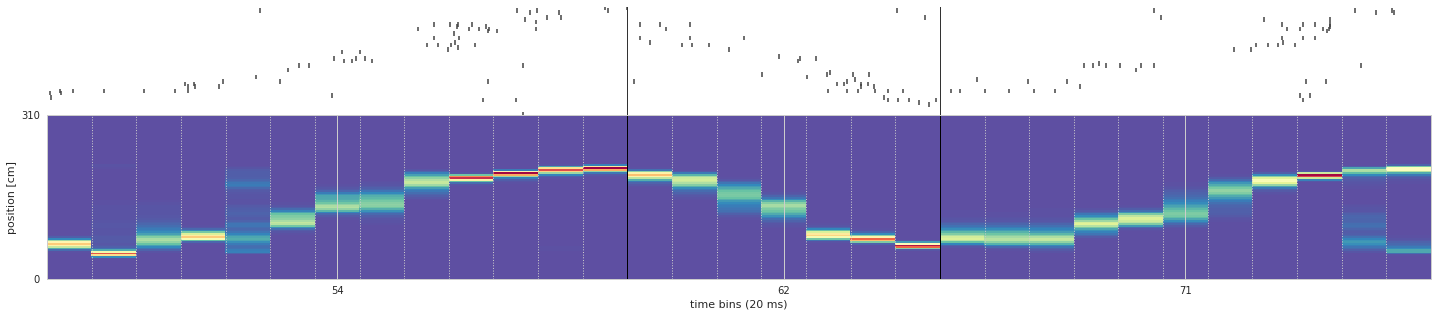

In [64]:
niceseq = [54, 62, 71]
plot_all_PBEs(bst, st, tc, tc_placecells, idx=niceseq, size='big')


#### How do we simulate the effect of SWR firing patterns being different in different conditions?

I propose that there's a dual - an change in firing rate in the place cells is equivalent to the tuning curves being scaled. So below, let's plot what happens if we take the tuning curves and scale all their firing rates by a factor of two. The decoded position becomes tighter!

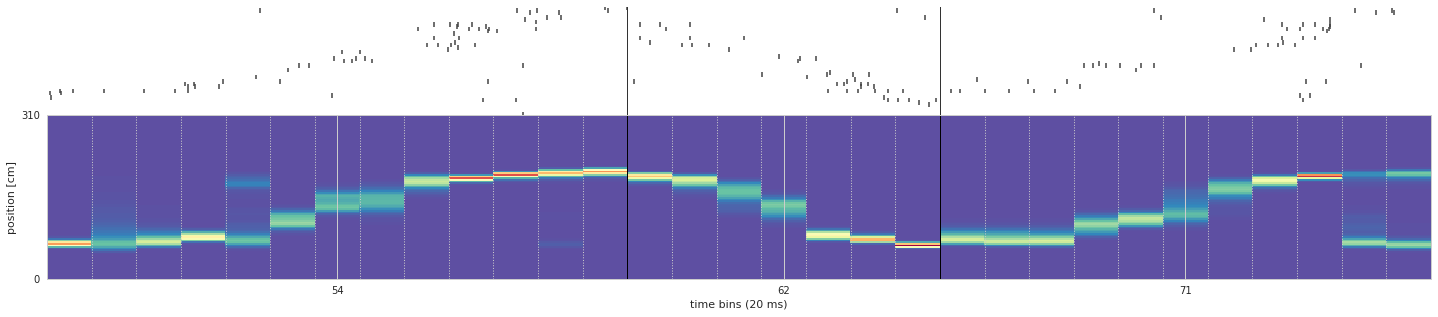

In [65]:
tc2 = tc * 0.1 # simulate a different firing rate map
plot_all_PBEs(bst, st, tc2, tc_placecells, idx=niceseq, size='big')


#### What is the effect on replay scores?

We'll use the Davidson-style replay detection on the two different tuning curve cases. What we see is that the tighter tuning corresponds to a more extreme (e.g., higher percentile) score.

In [66]:
from nelpy import analysis

scores, shuffled_scores, percentiles = \
    nel.analysis.replay.score_Davidson_final_bst_fast(bst=bst[niceseq],
        tuningcurve=tc,w=3,n_shuffles=100, n_samples=1000)

scores2, shuffled_scores2, percentiles2 = \
    nel.analysis.replay.score_Davidson_final_bst_fast(bst=bst[niceseq],
        tuningcurve=tc2,w=3,n_shuffles=100, n_samples=1000)



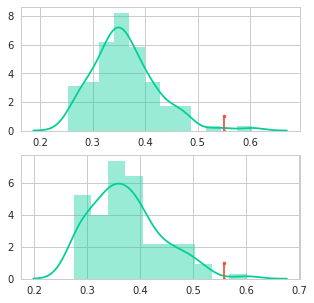

[0.48869989 0.55083537 0.44889918] [0.43758774 0.55839574 0.40604443]
[100.  99. 100.] [100.  99. 100.]


In [62]:
import seaborn as sns
with npl.FigureManager(show=True, figsize=(5,5), nrows=2) as (fig, ax):
    npl.setup(style='whitegrid')
    sns.distplot(shuffled_scores[1,:],ax=ax[0])
    ax[0].plot([scores[1],scores[1]],[0,1],'.-')
    sns.distplot(shuffled_scores2[1,:],ax=ax[1])
    ax[1].plot([scores2[1],scores2[1]],[0,1],'.-')

print(scores, scores2)
print(percentiles, percentiles2)